# Compare With Random Method


In [1]:
import random
import numpy as np
import scipy.sparse

from exputils.dot.get_topK_Amat import get_topK_Amat
from exputils.dot.recovery_state import recovery_states_from_idxs
from exputils.extent.custom import calculate_extent_custom
from exputils.stabilizer_group import total_stabilizer_group_size
from exputils.state.random_ket import make_random_quantum_state
from exputils.extent.cg import calculate_extent_CG

CG: n=7, method='mosek'
start: calculate dots
[k|progress|range]: 1 | 3.26400e+04/8.12849e+10 | [0.09567, 0.30373] | 12[ms]
[k|progress|range]: 2 | 2.76365e+06/8.12849e+10 | [0.21003, 0.34968] | 195[ms]
[k|progress|range]: 3 | 9.95194e+07/8.12849e+10 | [0.26630, 0.37190] | 918[ms]
[k|progress|range]: 4 | 1.64761e+09/8.12849e+10 | [0.30183, 0.41110] | 2171[ms]
[k|progress|range]: 5 | 1.28338e+10/8.12849e+10 | [0.32515, 0.41110] | 4823[ms]
[k|progress|range]: 6 | 4.69251e+10/8.12849e+10 | [0.33910, 0.41908] | 9156[ms]
[k|progress|range]: 7 | 8.12849e+10/8.12849e+10 | [0.34461, 0.41908] | 12616[ms]
 calculation time : 12616[ms]
branch cut / total: 80838137344/81284860800
iteration: 1 / 100, Amat.shape = (128, 10000)
start: solve SOCP
stabilizer_extent=7.430282225289089
start: calculate dual dots
[k|progress|range]: 1 | 3.26400e+04/8.12849e+10 | [nan, nan] | 4[ms]
[k|progress|range]: 2 | 2.76365e+06/8.12849e+10 | [nan, nan] | 46[ms]
[k|progress|range]: 3 | 9.95194e+07/8.12849e+10 | [1.0032

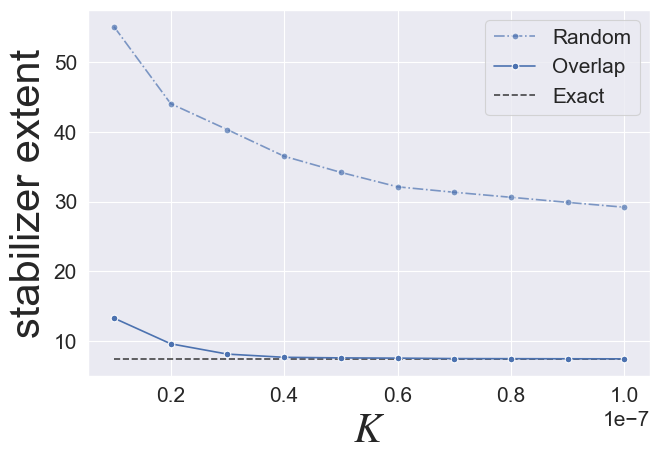

In [3]:
def calculate_extent_random(n, psi, _K, _, rand_Amat):
    assert _K in np.linspace(0.1, 1.0, 10)
    Amat = scipy.sparse.hstack(
        [
            rand_Amat[:, : int(_K * rand_Amat.shape[1])],
            scipy.sparse.eye(2**n, format="csc", dtype=np.complex128),
        ]
    )
    assert Amat.shape[0] == (1 << n)
    assert Amat.shape[1] <= int(_K * total_stabilizer_group_size(n)) + 2**n
    print(f"random: {Amat.shape=}")
    return calculate_extent_custom(n, Amat, psi)[0]


def calculate_extent_dot(n, psi, _K, topK_Amat, _):
    assert _K in np.linspace(0.1, 1.0, 10)
    Amat = scipy.sparse.hstack(
        [
            topK_Amat[:, : int(_K * topK_Amat.shape[1])],
            scipy.sparse.eye(2**n, format="csc", dtype=np.complex128),
        ]
    )
    print(f"dot: {Amat.shape=}")
    return calculate_extent_custom(n, Amat, psi)[0]


def execute_experiments(n, maxK, kind):
    log_file_name = f"../data/random_vs_overlap/{kind}_{n}_data.txt"

    seed = 0
    psi = make_random_quantum_state(kind, n, seed)
    exact = calculate_extent_CG(n, psi)[0]
    with open(log_file_name, mode="w") as f:
        print(f"{exact=}", file=f)

    t_s_g_s = total_stabilizer_group_size(n)
    topK_Amat = get_topK_Amat(n, psi, False)
    topK_Amat = topK_Amat[:, np.argsort(np.abs(topK_Amat.conj().T @ psi))[::-1]]
    rand_Amat = recovery_states_from_idxs(
        n, random.sample(range(t_s_g_s), int(t_s_g_s * maxK))
    )
    assert topK_Amat.shape[1] >= rand_Amat.shape[1], (topK_Amat.shape, rand_Amat.shape)
    topK_Amat = topK_Amat[:, : rand_Amat.shape[1]]

    methods = ["Random", "Overlap", "Exact"]
    functions = [calculate_extent_random, calculate_extent_dot, lambda *args: exact]
    for method, func in zip(methods, functions):
        for _K in np.linspace(0.1, 1.0, 10):
            if method != "Exact":
                print(f"{method=} {_K=:.3e}", end=" ")
            extent = func(n, psi, _K, topK_Amat, rand_Amat)
            K = _K * maxK
            with open(log_file_name, mode="a") as f:
                print(f"{n=}, {seed=}, {K=:.3e}, {method=}, {extent=}", file=f)
    print("done")


if __name__ == "__main__":
    # execute_experiments(5, 1e-4, "pure")
    execute_experiments(7, 1e-7, "pure")